In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import math
import random
import os
import os.path
import numpy as np
import logging
import argparse
from argparse import ZERO_OR_MORE
from torch.nn.modules.module import T
from torch.utils.tensorboard import SummaryWriter as writer
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import time

Parameters

In [3]:
epochs = 150
batch_size = 32 # reduced from 250 to 32
n_steps = 16 # timestep
in_channels = 1
lr = 0.001
# n_class = 10
latent_dim = 35 # changed from 128 to 25
input_size = 40
k = 20 # multiplier of channel
# scheduled = True # whether to apply scheduled sampling
# checkpoint_filename = 'svae_checkpoint_32_16_250_100000_dim25.pth'
save_folder = '/content/drive/MyDrive/TU060/Dissertation/Models/V3/SVAE/z_dim = 35/40k'
# Check if the directory exists, if not, create it
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Load data

In [4]:
# Load data
# raw = np.load('/content/drive/MyDrive/TU060/Dissertation/Dataset/sampled_maps_10000_01.npy')
# raw = np.load('/content/drive/MyDrive/TU060/Dissertation/Dataset/sampled_maps_20000_01.npy')
raw = np.load('/content/drive/MyDrive/TU060/Dissertation/Dataset/sampled_maps_40000_01.npy')
# raw = np.load('/content/drive/MyDrive/TU060/Dissertation/Dataset/sampled_maps_80000_01.npy')
# raw = np.load('/content/drive/MyDrive/TU060/Dissertation/Dataset/sampled_maps_160000_01.npy')
# raw = np.load('/content/drive/MyDrive/TU060/Dissertation/Dataset/TopoMaps_s01.npy')
# Normalise data between 0 and 1
# data_norm = (raw - raw.min()) / (raw.max() - raw.min())
# Normalise data between -1 and 1
# data_norm = (raw - raw.min()) / (raw.max() - raw.min()) * 2 - 1

# Initialize normalized data array
data_norm = np.zeros_like(raw)

# Normalize each image individually
for i in range(len(raw)):
    min_val = raw[i].min()
    max_val = raw[i].max()
    data_norm[i] = (raw[i] - min_val) / (max_val - min_val)

# Reshape data to have a single channel
data_norm_reshape = data_norm.reshape(-1, 1, raw.shape[1], raw.shape[2]).astype(np.float32)


# Split data into training, validation, and testing
data_train, data_test = train_test_split(data_norm_reshape, test_size=0.3, random_state=42, shuffle=True)
data_test, data_val = train_test_split(data_test, test_size=0.5, random_state=42, shuffle=True)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

# FSVAE models

## SNN layers

In [5]:
# SNN layers

dt = 5
a = 0.25
aa = 0.5
Vth = 0.2
tau = 0.25


class SpikeAct(torch.autograd.Function):
    """
        Implementation of the spiking activation function with an approximation of gradient.
    """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # if input = u > Vth then output = 1
        output = torch.gt(input, Vth)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(input) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu

class LIFSpike(nn.Module):
    """
        Generates spikes based on LIF module. It can be considered as an activation function and is used similar to ReLU. The input tensor needs to have an additional time dimension, which in this case is on the last dimension of the data.
    """
    def __init__(self):
        super(LIFSpike, self).__init__()

    def forward(self, x):
        nsteps = x.shape[-1]
        u   = torch.zeros(x.shape[:-1] , device=x.device)
        out = torch.zeros(x.shape, device=x.device)
        for step in range(nsteps):
            u, out[..., step] = self.state_update(u, out[..., max(step-1, 0)], x[..., step])
        return out

    def state_update(self, u_t_n1, o_t_n1, W_mul_o_t1_n, tau=tau):
        u_t1_n1 = tau * u_t_n1 * (1 - o_t_n1) + W_mul_o_t1_n
        o_t1_n1 = SpikeAct.apply(u_t1_n1)
        return u_t1_n1, o_t1_n1

class tdLinear(nn.Linear):
    def __init__(self,
                in_features,
                out_features,
                bias=True,
                bn=None,
                spike=None):
        assert type(in_features) == int, 'inFeatures should not be more than 1 dimesnion. It was: {}'.format(in_features.shape)
        assert type(out_features) == int, 'outFeatures should not be more than 1 dimesnion. It was: {}'.format(out_features.shape)

        super(tdLinear, self).__init__(in_features, out_features, bias=bias)

        self.bn = bn
        self.spike = spike


    def forward(self, x):
        """
        x : (N,C,T)
        """
        x = x.transpose(1, 2) # (N, T, C)
        y = F.linear(x, self.weight, self.bias)
        y = y.transpose(1, 2)# (N, C, T)

        if self.bn is not None:
            y = y[:,:,None,None,:]
            y = self.bn(y)
            y = y[:,:,0,0,:]
        if self.spike is not None:
            y = self.spike(y)
        return y

class tdConv(nn.Conv3d):
    def __init__(self,
                in_channels,
                out_channels,
                kernel_size,
                stride=1,
                padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None,
                is_first_conv=False):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))

        super(tdConv, self).__init__(in_channels, out_channels, kernel, stride, padding, dilation, groups,
                                        bias=bias)
        self.bn = bn
        self.spike = spike
        self.is_first_conv = is_first_conv

    def forward(self, x):
        x = F.conv3d(x, self.weight, self.bias,
                        self.stride, self.padding, self.dilation, self.groups)
        if self.bn is not None:
            x = self.bn(x)
        if self.spike is not None:
            x = self.spike(x)
        return x


class tdConvTranspose(nn.ConvTranspose3d):
    def __init__(self,
                in_channels,
                out_channels,
                kernel_size,
                stride=1,
                padding=0,
                output_padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))


        # output padding
        if type(output_padding) == int:
            output_padding = (output_padding, output_padding, 0)
        elif len(output_padding) == 2:
            output_padding = (output_padding[0], output_padding[1], 0)
        else:
            raise Exception('output_padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        super().__init__(in_channels, out_channels, kernel, stride, padding, output_padding, groups,
                                        bias=bias, dilation=dilation)

        self.bn = bn
        self.spike = spike

    def forward(self, x):
        x = F.conv_transpose3d(x, self.weight, self.bias,
                        self.stride, self.padding,
                        self.output_padding, self.groups, self.dilation)

        if self.bn is not None:
            x = self.bn(x)
        if self.spike is not None:
            x = self.spike(x)
        return x

class tdBatchNorm(nn.BatchNorm2d):
    """
        Implementation of tdBN. Link to related paper: https://arxiv.org/pdf/2011.05280. In short it is averaged over the time domain as well when doing BN.
    Args:
        num_features (int): same with nn.BatchNorm2d
        eps (float): same with nn.BatchNorm2d
        momentum (float): same with nn.BatchNorm2d
        alpha (float): an addtional parameter which may change in resblock.
        affine (bool): same with nn.BatchNorm2d
        track_running_stats (bool): same with nn.BatchNorm2d
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, alpha=1, affine=True, track_running_stats=True):
        super(tdBatchNorm, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, input):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3, 4])
            # use biased var in train
            var = input.var([0, 2, 3, 4], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = self.alpha * Vth * (input - mean[None, :, None, None, None]) / (torch.sqrt(var[None, :, None, None, None] + self.eps))
        if self.affine:
            input = input * self.weight[None, :, None, None, None] + self.bias[None, :, None, None, None]

        return input


class PSP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tau_s = 2

    def forward(self, inputs):
        """
        inputs: (N, C, T)
        """
        syns = None
        syn = 0
        n_steps = inputs.shape[-1]
        for t in range(n_steps):
            syn = syn + (inputs[...,t] - syn) / self.tau_s
            if syns is None:
                syns = syn.unsqueeze(-1)
            else:
                syns = torch.cat([syns, syn.unsqueeze(-1)], dim=-1)

        return syns

class MembraneOutputLayer(nn.Module):
    """
    outputs the last time membrane potential of the LIF neuron with V_th=infty
    """
    def __init__(self) -> None:
        super().__init__()
        # n_steps = glv.n_steps

        arr = torch.arange(n_steps-1,-1,-1)
        self.register_buffer("coef", torch.pow(0.8, arr)[None,None,None,None,:]) # (1,1,1,1,T)

    def forward(self, x):
        """
        x : (N,C,H,W,T)
        """
        out = torch.sum(x*self.coef, dim=-1)
        return out

## FSVAE posterior

In [6]:
class PosteriorBernoulliSTBP(nn.Module):
    def __init__(self, k=20) -> None:
        """
        modeling of q(z_t | x_<=t, z_<t)
        """
        super().__init__()
        self.channels = latent_dim
        self.k = k
        self.n_steps = n_steps

        self.layers = nn.Sequential(
            tdLinear(self.channels*2,
                    self.channels*2,
                    bias=True,
                    bn=tdBatchNorm(self.channels*2, alpha=2),
                    spike=LIFSpike()),
            tdLinear(self.channels*2,
                    self.channels*4,
                    bias=True,
                    bn=tdBatchNorm(self.channels*4, alpha=2),
                    spike=LIFSpike()),
            tdLinear(self.channels*4,
                    self.channels*k,
                    bias=True,
                    bn=tdBatchNorm(self.channels*k, alpha=2),
                    spike=LIFSpike())
        )
        self.register_buffer('initial_input', torch.zeros(1, self.channels, 1))# (1,C,1)

        self.is_true_scheduled_sampling = True

    def forward(self, x):
        """
        input:
            x:(B,C,T)
        returns:
            sampled_z:(B,C,T)
            q_z: (B,C,k,T) # indicates q(z_t | x_<=t, z_<t) (t=1,...,T)
        """
        x_shape = x.shape # (B,C,T)
        batch_size=x_shape[0]
        random_indices = []
        # sample z inadvance without gradient
        with torch.no_grad():
            z_t_minus = self.initial_input.repeat(x_shape[0],1,1) # z_<t z0=zeros:(B,C,1)
            for t in range(self.n_steps-1):
                inputs = torch.cat([x[...,:t+1].detach(), z_t_minus.detach()], dim=1) # (B,C+C,t+1) x_<=t and z_<t
                outputs = self.layers(inputs) #(B, C*k, t+1)
                q_z_t = outputs[...,-1] # (B, C*k, 1) q(z_t | x_<=t, z_<t)

                # sampling from q(z_t | x_<=t, z_<t)
                random_index = torch.randint(0, self.k, (batch_size*self.channels,)) \
                            + torch.arange(start=0, end=batch_size*self.channels*self.k, step=self.k) #(B*C,) select 1 from every k value
                random_index = random_index.to(x.device)
                random_indices.append(random_index)

                z_t = q_z_t.view(batch_size*self.channels*self.k)[random_index] # (B*C,)
                z_t = z_t.view(batch_size, self.channels, 1) #(B,C,1)

                z_t_minus = torch.cat([z_t_minus, z_t], dim=-1) # (B,C,t+2)

        z_t_minus = z_t_minus.detach() # (B,C,T) z_0,...,z_{T-1}
        q_z = self.layers(torch.cat([x, z_t_minus], dim=1)) # (B,C*k,T)

        # input z_t_minus again to calculate tdBN
        sampled_z = None
        for t in range(self.n_steps):

            if t == self.n_steps-1:
                # when t=T
                random_index = torch.randint(0, self.k, (batch_size*self.channels,)) \
                            + torch.arange(start=0, end=batch_size*self.channels*self.k, step=self.k)
                random_indices.append(random_index)
            else:
                # when t<=T-1
                random_index = random_indices[t]

            # sampling
            sampled_z_t = q_z[...,t].view(batch_size*self.channels*self.k)[random_index] # (B*C,)
            sampled_z_t = sampled_z_t.view(batch_size, self.channels, 1) #(B,C,1)
            if t==0:
                sampled_z = sampled_z_t
            else:
                sampled_z = torch.cat([sampled_z, sampled_z_t], dim=-1)

        q_z = q_z.view(batch_size, self.channels, self.k, self.n_steps)# (B,C,k,T)

        return sampled_z, q_z

## FSVAE prior

In [7]:
class PriorBernoulliSTBP(nn.Module):
    def __init__(self, k=20) -> None:
        """
        modeling of p(z_t|z_<t)
        """
        super().__init__()
        self.channels = latent_dim
        self.k = k
        self.n_steps = n_steps

        self.layers = nn.Sequential(
            tdLinear(self.channels,
                    self.channels*2,
                    bias=True,
                    bn=tdBatchNorm(self.channels*2, alpha=2),
                    spike=LIFSpike()),
            tdLinear(self.channels*2,
                    self.channels*4,
                    bias=True,
                    bn=tdBatchNorm(self.channels*4, alpha=2),
                    spike=LIFSpike()),
            tdLinear(self.channels*4,
                    self.channels*k,
                    bias=True,
                    bn=tdBatchNorm(self.channels*k, alpha=2),
                    spike=LIFSpike())
        )
        self.register_buffer('initial_input', torch.zeros(1, self.channels, 1))# (1,C,1)


    def forward(self, z, scheduled=False, p=None):
        if scheduled:
            return self._forward_scheduled_sampling(z, p)
        else:
            return self._forward(z)

    def _forward(self, z):
        """
        input z: (B,C,T) # latent spike sampled from posterior
        output : (B,C,k,T) # indicates p(z_t|z_<t) (t=1,...,T)
        """
        z_shape = z.shape # (B,C,T)
        batch_size = z_shape[0]
        z = z.detach()

        z0 = self.initial_input.repeat(batch_size, 1, 1) # (B,C,1)
        inputs = torch.cat([z0, z[...,:-1]], dim=-1) # (B,C,T)
        outputs = self.layers(inputs) # (B,C*k,T)

        p_z = outputs.view(batch_size, self.channels, self.k, self.n_steps) # (B,C,k,T)
        return p_z

    def _forward_scheduled_sampling(self, z, p):
        """
        use scheduled sampling
        input
            z: (B,C,T) # latent spike sampled from posterior
            p: float # prob of scheduled sampling
        output : (B,C,k,T) # indicates p(z_t|z_<t) (t=1,...,T)
        """
        z_shape = z.shape # (B,C,T)
        batch_size = z_shape[0]
        z = z.detach()

        z_t_minus = self.initial_input.repeat(batch_size,1,1) # z_<t, z0=zeros:(B,C,1)
        if self.training:
            with torch.no_grad():
                for t in range(self.n_steps-1):
                    if t>=5 and random.random() < p: # scheduled sampling
                        outputs = self.layers(z_t_minus.detach()) #binary (B, C*k, t+1) z_<=t
                        p_z_t = outputs[...,-1] # (B, C*k, 1)
                        # sampling from p(z_t | z_<t)
                        prob1 = p_z_t.view(batch_size, self.channels, self.k).mean(-1) # (B,C)
                        prob1 = prob1 + 1e-3 * torch.randn_like(prob1)
                        z_t = (prob1>0.5).float() # (B,C)
                        z_t = z_t.view(batch_size, self.channels, 1) #(B,C,1)
                        z_t_minus = torch.cat([z_t_minus, z_t], dim=-1) # (B,C,t+2)
                    else:
                        z_t_minus = torch.cat([z_t_minus, z[...,t].unsqueeze(-1)], dim=-1) # (B,C,t+2)
        else: # for test time
            z_t_minus = torch.cat([z_t_minus, z[:,:,:-1]], dim=-1) # (B,C,T)

        z_t_minus = z_t_minus.detach() # (B,C,T) z_{<=T-1}
        p_z = self.layers(z_t_minus) # (B,C*k,T)
        p_z = p_z.view(batch_size, self.channels, self.k, self.n_steps)# (B,C,k,T)
        return p_z

    def sample(self, batch_size=64):
        z_minus_t = self.initial_input.repeat(batch_size, 1, 1) # (B, C, 1)
        for t in range(self.n_steps):
            outputs = self.layers(z_minus_t) # (B, C*k, t+1)
            p_z_t = outputs[...,-1] # (B, C*k, 1)

            random_index = torch.randint(0, self.k, (batch_size*self.channels,)) \
                            + torch.arange(start=0, end=batch_size*self.channels*self.k, step=self.k) #(B*C,) pick one from k
            random_index = random_index.to(z_minus_t.device)

            z_t = p_z_t.view(batch_size*self.channels*self.k)[random_index] # (B*C,)
            z_t = z_t.view(batch_size, self.channels, 1) #(B,C,1)
            z_minus_t = torch.cat([z_minus_t, z_t], dim=-1) # (B,C,t+2)


        sampled_z = z_minus_t[...,1:] # (B,C,T)

        return sampled_z

## FSVAE

In [8]:
# FSVAE
class FSVAE(nn.Module):
    def __init__(self, in_channels, latent_dim, n_steps, k):
        super().__init__()
        in_channels = in_channels
        self.latent_dim = latent_dim
        self.n_steps = n_steps
        self.k = k

        hidden_dims = [32, 64, 128]
        self.hidden_dims = hidden_dims.copy()

        # Build Encoder
        modules = []
        is_first_conv = True
        for h_dim in hidden_dims:
            modules.append(
                tdConv(in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        bias=True,
                        bn=tdBatchNorm(h_dim),
                        spike=LIFSpike(),
                        is_first_conv=is_first_conv)
            )
            in_channels = h_dim
            is_first_conv = False

        self.encoder = nn.Sequential(*modules)
        self.before_latent_layer = tdLinear(hidden_dims[-1]*25, # changed from 4 to 25
                                            latent_dim,
                                            bias=True,
                                            bn=tdBatchNorm(latent_dim),
                                            spike=LIFSpike())

        self.prior = PriorBernoulliSTBP(self.k)

        self.posterior = PosteriorBernoulliSTBP(self.k)

        # Build Decoder
        modules = []

        self.decoder_input = tdLinear(latent_dim,
                                        hidden_dims[-1] * 25, # changed from 4 to 25
                                        bias=True,
                                        bn=tdBatchNorm(hidden_dims[-1] * 25), # changed from 4 to 25
                                        spike=LIFSpike())

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                    tdConvTranspose(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=1,
                                    output_padding=1,
                                    bias=True,
                                    bn=tdBatchNorm(hidden_dims[i+1]),
                                    spike=LIFSpike())
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            tdConvTranspose(hidden_dims[-1],
                                            hidden_dims[-1],
                                            kernel_size=3,
                                            stride=2,
                                            padding=1,
                                            output_padding=1,
                                            bias=True,
                                            bn=tdBatchNorm(hidden_dims[-1]),
                                            spike=LIFSpike()),
                            tdConvTranspose(hidden_dims[-1],
                                            out_channels=1, # changed from in_channels to 1
                                            kernel_size=3,
                                            padding=1,
                                            bias=True,
                                            bn=None,
                                            spike=None)
        )

        self.p = 0

        self.membrane_output_layer = MembraneOutputLayer()

        self.psp = PSP()

    def forward(self, x, scheduled=False):
        sampled_z, q_z, p_z = self.encode(x)
        x_recon = self.decode(sampled_z)
        return x_recon, q_z, p_z, sampled_z

    def encode(self, x, scheduled=False):
        # print(f"encoder input {x.shape}")
        x = self.encoder(x) # (N,C,H,W,T)
        # print(f"encoder {x.shape}")
        x = torch.flatten(x, start_dim=1, end_dim=3) # (N,C*H*W,T)
        # print(f"flattened {x.shape}")
        latent_x = self.before_latent_layer(x) # (N,latent_dim,T)
        # print(f"latent {latent_x.shape}")
        sampled_z, q_z = self.posterior(latent_x) # sampled_z:(B,C,1,1,T), q_z:(B,C,k,T)

        p_z = self.prior(sampled_z, scheduled, self.p)
        # print(f"sampled_z {sampled_z.shape}, q_z {q_z.shape}, p_z {p_z.shape}")
        return sampled_z, q_z, p_z

    def decode(self, z):
        # print(f"decoder input {z.shape}")
        result = self.decoder_input(z) # (N,C*H*W,T)
        # print(f"decoder processed {result.shape}")
        result = result.view(result.shape[0], self.hidden_dims[-1], 5, 5, self.n_steps) # (N,C,H,W,T), changed from 2 to 5
        # print(f"decoder reshaped {result.shape}")
        result = self.decoder(result)# (N,C,H,W,T)
        # print(f"decoder {result.shape}")
        result = self.final_layer(result)# (N,C,H,W,T)
        # print(f"decoder final {result.shape}")
        # out = torch.tanh(self.membrane_output_layer(result)) # tanh as original
        out = torch.sigmoid(self.membrane_output_layer(result)) # changed from tanh to sigmoid
        # print(f"decoder out {out.shape}")
        return out

    def sample(self, batch_size=64):
        sampled_z = self.prior.sample(batch_size)
        sampled_x = self.decode(sampled_z)
        return sampled_x, sampled_z

    def loss_function_mmd(self, input_img, recons_img, q_z, p_z):
        """
        q_z is q(z|x): (N,latent_dim,k,T)
        p_z is p(z): (N,latent_dim,k,T)
        """
        recons_loss = F.mse_loss(recons_img, input_img)
        q_z_ber = torch.mean(q_z, dim=2) # (N, latent_dim, T)
        p_z_ber = torch.mean(p_z, dim=2) # (N, latent_dim, T)

        #kld_loss = torch.mean((q_z_ber - p_z_ber)**2)
        mmd_loss = torch.mean((self.psp(q_z_ber)-self.psp(p_z_ber))**2)
        loss = recons_loss + mmd_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'Distance_Loss': mmd_loss}

    def weight_clipper(self):
        with torch.no_grad():
            for p in self.parameters():
                p.data.clamp_(-4,4)

    def update_p(self, epoch, max_epoch):
        init_p = 0.1
        last_p = 0.3
        self.p = (last_p-init_p) * epoch / max_epoch + init_p

# Utils

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Main FSVAE

In [22]:
# Define the directory to save the model checkpoints
checkpoint_dir = '/content/drive/MyDrive/TU060/Dissertation/Checkpoints/V3'

# Check if the checkpoint directory exists, if not, create it
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define a function to save the model checkpoint after every epoch
def save_checkpoint(epoch, model, optimizer, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, filename))

In [23]:
# Create an instance of the FSVAE class
network = FSVAE(in_channels, latent_dim, n_steps, k)
# net = net.to(torch.device("cpu"))

optimizer = torch.optim.AdamW(network.parameters(),
                            lr=lr,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)

# Initialize variables for early stopping
best_val_loss = 0.0209906618098417 #float('inf')
patience = 6 #0
patience_limit = 10  # Number of epochs without improvement before stopping

# Check if there is a checkpoint file available
start_epoch = 0
if os.path.exists('/content/drive/MyDrive/TU060/Dissertation/Checkpoints/V3/svae3_checkpoint_35_40000_43.pth'):
    checkpoint = torch.load('/content/drive/MyDrive/TU060/Dissertation/Checkpoints/V3/svae3_checkpoint_35_40000_43.pth')
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['loss']
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Resuming from epoch {start_epoch + 1}")

# Initialize lists to store training and validation losses
train_losses_list = []
val_losses_list = []

# Initialize lists to store evaluation metrics
train_metrics_list = []
val_metrics_list = []

total_start_time = time.time()

for epoch in range(start_epoch + 1, epochs):
    # Training phase
    network.train()
    train_loss = 0.0
    start_time = time.time()
    train_reconstruction = []
    train_data = []

    # Training loop
    for batch_index, data_batch in enumerate(train_loader):
        optimizer.zero_grad()
        spike_input = data_batch.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps)
        x_recon, q_z, p_z, sampled_z = network(spike_input)
        losses = network.loss_function_mmd(data_batch, x_recon, q_z, p_z)
        losses['loss'].backward()
        optimizer.step()
        train_loss += losses['loss'].detach().item() * data_batch.size(0)

        # Print progress of batches
        # print(f"Epoch [{epoch}/{epochs}], Batch [{batch_index}/{len(train_loader)}], Train Loss: {losses['loss'].item():.4f}")

        train_reconstruction.append(x_recon.detach().numpy())
        train_data.append(data_batch.detach().numpy())

    train_loss /= len(train_loader.dataset)

    # Concatenate training data
    train_data = np.concatenate(train_data, axis=0)
    train_reconstruction = np.concatenate(train_reconstruction, axis=0)
    train_reconstruction = np.squeeze(train_reconstruction)

    train_data_flat = train_data.reshape(-1, train_data.shape[2] * train_data.shape[3])  # Flatten to 2D array
    train_reconstruction_flat = train_reconstruction.reshape(-1, train_reconstruction.shape[1] * train_reconstruction.shape[2])  # Flatten to 2D array

    # Compute training metrics
    train_metrics = {
        'MSE': mean_squared_error(train_data_flat, train_reconstruction_flat),
        'MAE': mean_absolute_error(train_data_flat, train_reconstruction_flat),
        'SSIM': ssim(train_data_flat, train_reconstruction_flat, data_range=train_reconstruction_flat.max() - train_reconstruction_flat.min())
        # 'MAPE': mean_absolute_percentage_error(train_data_flat, train_reconstruction_flat)
    }
    train_metrics_list.append(train_metrics)

    # Validation phase
    network.eval()
    val_loss = 0.0
    val_reconstruction = []
    val_data = []

    with torch.no_grad():
        for batch_idx, data_batch in enumerate(val_loader):
            spike_input = data_batch.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps)
            x_recon, q_z, p_z, sampled_z = network(spike_input)
            val_losses = network.loss_function_mmd(data_batch, x_recon, q_z, p_z)
            val_loss += val_losses['loss'].detach().item() * data_batch.size(0)

            val_reconstruction.append(x_recon.detach().numpy())
            val_data.append(data_batch.detach().numpy())

    val_loss /= len(val_loader.dataset)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch [{epoch}/{epochs}], Time: {epoch_time:.2f} seconds")

    # Concatenate validation data
    val_data = np.concatenate(val_data, axis=0)
    val_reconstruction = np.concatenate(val_reconstruction, axis=0)
    val_reconstruction = np.squeeze(val_reconstruction)

    val_data_flat = val_data.reshape(-1, val_data.shape[2] * val_data.shape[3])  # Flatten to 2D array
    val_reconstruction_flat = val_reconstruction.reshape(-1, val_reconstruction.shape[1] * val_reconstruction.shape[2])  # Flatten to 2D array

    # Compute validation metrics
    val_metrics = {
        'MSE': mean_squared_error(val_data_flat, val_reconstruction_flat),
        'MAE': mean_absolute_error(val_data_flat, val_reconstruction_flat),
        'SSIM': ssim(val_data_flat, val_reconstruction_flat, data_range=val_reconstruction_flat.max() - val_reconstruction_flat.min())
        # 'MAPE': mean_absolute_percentage_error(val_data_flat, val_reconstruction_flat)
    }
    val_metrics_list.append(val_metrics)

    print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}")
    print(f"Epoch [{epoch}/{epochs}], Train MSE: {train_metrics['MSE']}, Train MAE: {train_metrics['MAE']}, Train SSIM: {train_metrics['SSIM']}")
    print(f"Epoch [{epoch}/{epochs}], Val MSE: {val_metrics['MSE']}, Val MAE: {val_metrics['MAE']}, Val SSIM: {val_metrics['SSIM']}")

    # Save losses to lists
    train_losses_list.append(train_loss)
    val_losses_list.append(val_loss)

    # Save model checkpoint after every epoch
    save_checkpoint(epoch, network, optimizer, best_val_loss, f'svae3_checkpoint_35_40000_{epoch}.pth')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        # Save the model to the specified folder
        model_path = os.path.join(save_folder, 'best_model.pth')
        torch.save(network.state_dict(), model_path)
    else:
        patience += 1

    # Early stopping
    if patience > patience_limit:
        print("Early stopping! No improvement in validation loss.")
        break

    # Save losses as CSV after every epoch
    csv_path = os.path.join(save_folder, 'svae3_35_40000_3.csv')
    losses_df = pd.DataFrame({
        'Epoch': range(start_epoch + 1, epoch + 1),
        'Train Loss': train_losses_list,
        'Validation Loss': val_losses_list,
        'Train MSE': [metrics['MSE'] for metrics in train_metrics_list],
        'Train MAE': [metrics['MAE'] for metrics in train_metrics_list],
        'Train SSIM': [metrics['SSIM'] for metrics in train_metrics_list],
        'Validation MSE': [metrics['MSE'] for metrics in val_metrics_list],
        'Validation MAE': [metrics['MAE'] for metrics in val_metrics_list],
        'Validation SSIM': [metrics['SSIM'] for metrics in val_metrics_list]
    })
    losses_df.to_csv(csv_path, index=False)

# Calculate time
total_end_time = time.time()
epoch_time = total_end_time - total_start_time
print(f"Total Time: {epoch_time:.2f} seconds")

Resuming from epoch 44
Epoch [44/150], Time: 1944.65 seconds
Epoch [44/150], Train Loss: 0.022316206257258143, Val Loss: 0.021465975254774092
Epoch [44/150], Train MSE: 0.012510651722550392, Train MAE: 0.08165962249040604, Train SSIM: 0.8133358665076761
Epoch [44/150], Val MSE: 0.011386104859411716, Val MAE: 0.0770406723022461, Val SSIM: 0.823357161030329
Epoch [45/150], Time: 1825.90 seconds
Epoch [45/150], Train Loss: 0.022332116823111262, Val Loss: 0.021242003709077834
Epoch [45/150], Train MSE: 0.012488579377532005, Train MAE: 0.08159269392490387, Train SSIM: 0.8132606204222455
Epoch [45/150], Val MSE: 0.011213080957531929, Val MAE: 0.07643300294876099, Val SSIM: 0.8276697448736964
Epoch [46/150], Time: 1917.29 seconds
Epoch [46/150], Train Loss: 0.022302378460764886, Val Loss: 0.0215326343079408
Epoch [46/150], Train MSE: 0.012505292892456055, Train MAE: 0.08165622502565384, Train SSIM: 0.8135466884990661
Epoch [46/150], Val MSE: 0.011638295836746693, Val MAE: 0.07806985080242157,

In [24]:
# # Save losses as CSV
# csv_path = os.path.join(save_folder, 'svae3_25_160000.csv')
# losses_df = pd.DataFrame({
#     'Epoch': range(start_epoch, epoch),
#     'Train Loss': train_losses_list,
#     'Validation Loss': val_losses_list,
#     'Train MSE': [metrics['MSE'] for metrics in train_metrics_list],
#     'Train MAE': [metrics['MAE'] for metrics in train_metrics_list],
#     'Train SSIM': [metrics['SSIM'] for metrics in train_metrics_list],
#     'Validation MSE': [metrics['MSE'] for metrics in val_metrics_list],
#     'Validation MAE': [metrics['MAE'] for metrics in val_metrics_list],
#     'Validation SSIM': [metrics['SSIM'] for metrics in val_metrics_list]
# })
# losses_df.to_csv(csv_path, index=False)

In [10]:
# # Load the model
# network = FSVAE(in_channels, latent_dim, n_steps, k)  # Assuming you have defined FSVAE appropriately
# checkpoint = torch.load('/content/drive/MyDrive/TU060/Dissertation/Checkpoints/V3/svae3_checkpoint_160000_20.pth')
# network.load_state_dict(checkpoint['model_state_dict'])
# network.eval()

model_path = os.path.join(save_folder, 'best_model.pth')

# Load the model
network = FSVAE(in_channels, latent_dim, n_steps, k)
checkpoint = torch.load(model_path)
network.load_state_dict(checkpoint)

# Evaluation
reconstruction = []
data_test = []

with torch.no_grad():
    for batch_idx, data_batch in enumerate(test_loader):
        spike_input = data_batch.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps)
        x_recon, q_z, p_z, sampled_z = network(spike_input)

        reconstruction.append(x_recon.numpy())
        data_test.append(data_batch.numpy())

# Concatenate data_test
data_test = np.concatenate(data_test, axis=0)

# Calculate evaluation metrics
reconstruction = np.concatenate(reconstruction, axis=0)
reconstruction = np.squeeze(reconstruction)

data_test_flat = data_test.reshape(-1, data_test.shape[2] * data_test.shape[3])  # Flatten to 2D array
reconstruction_flat = reconstruction.reshape(-1, reconstruction.shape[1] * reconstruction.shape[2])  # Flatten to 2D array

mse = mean_squared_error(data_test_flat, reconstruction_flat)
mae = mean_absolute_error(data_test_flat, reconstruction_flat)
ssim_score = ssim(data_test_flat, reconstruction_flat,
                  data_range=reconstruction_flat.max() - reconstruction_flat.min())

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"SSIM: {ssim_score}")


Mean Squared Error: 0.012599319219589233
Mean Absolute Error: 0.08183120936155319
SSIM: 0.8098644211768367


In [11]:
recon_path = os.path.join(save_folder, 'reconstruction.npy')
np.save(recon_path, reconstruction)

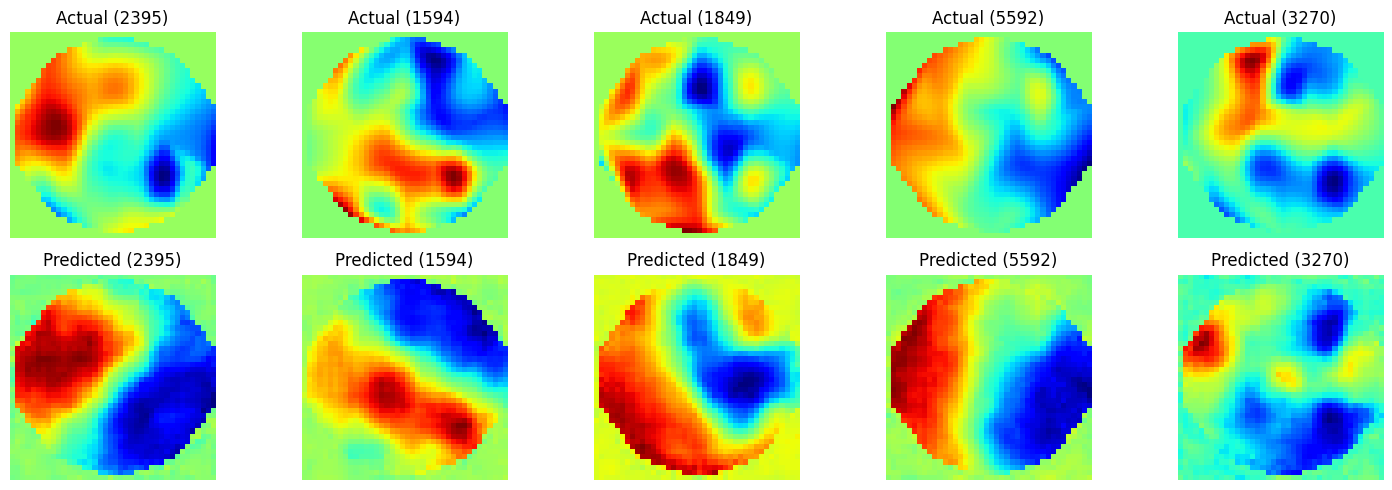

In [13]:
# Visualize actual and predicted images with sample indices
n_samples = 5  # Number of samples to visualize

# Select random samples
available_indices = list(range(len(data_test)))
indices = np.random.choice(available_indices, size=n_samples, replace=False)

# Plot actual and predicted images
fig, axes = plt.subplots(nrows=2, ncols=n_samples, figsize=(15, 5))

for i, idx in enumerate(indices):
    # Remove selected index from available indices
    available_indices.remove(idx)

    # Find maximum and minimum pixel values for the actual image
    max_pixel_value_actual = data_test[idx].max()
    min_pixel_value_actual = data_test[idx].min()

    # Plot actual image with index
    axes[0, i].imshow(data_test[idx].squeeze(), cmap='jet')
    axes[0, i].set_title(f"Actual ({idx})")
    axes[0, i].axis('off')

    # Plot predicted image with index using actual image's max and min pixel values
    reconstructed_img = reconstruction[idx]
    # reconstructed_img_clipped = np.clip(reconstructed_img, min_pixel_value_actual, max_pixel_value_actual)
    axes[1, i].imshow(reconstructed_img, cmap='jet')
    axes[1, i].set_title(f"Predicted ({idx})")
    axes[1, i].axis('off')

plt.tight_layout()
img_path = os.path.join(save_folder, 'svae3_40000_35_1.png')
plt.savefig(img_path)
plt.show()

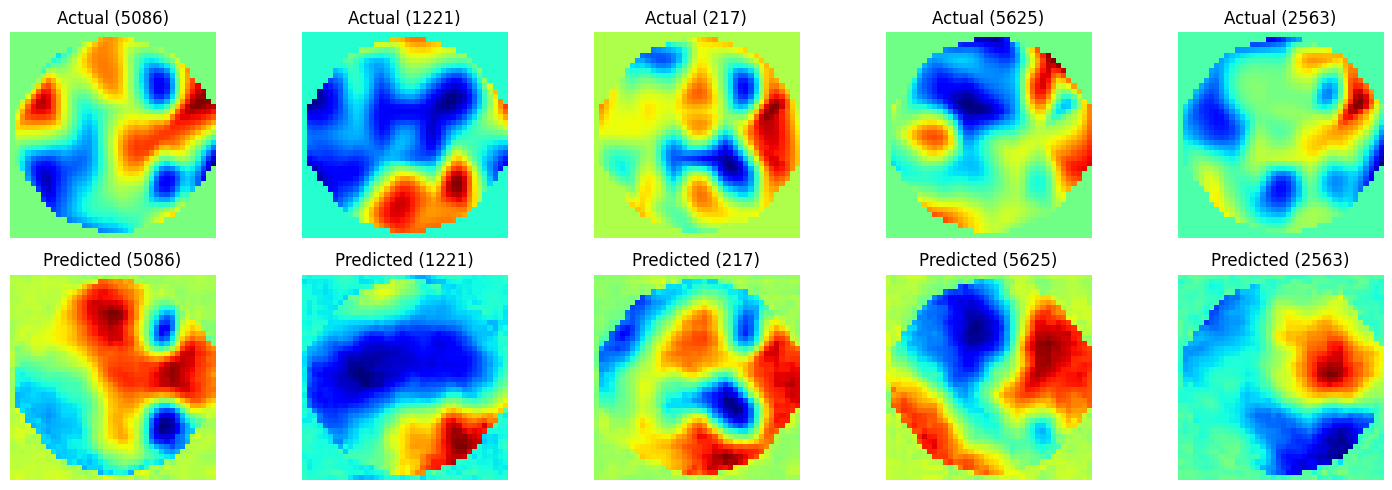

In [16]:
# Visualize actual and predicted images with sample indices
n_samples = 5  # Number of samples to visualize

# Select random samples
available_indices = list(range(len(data_test)))
indices = np.random.choice(available_indices, size=n_samples, replace=False)

# Plot actual and predicted images
fig, axes = plt.subplots(nrows=2, ncols=n_samples, figsize=(15, 5))

for i, idx in enumerate(indices):
    # Remove selected index from available indices
    available_indices.remove(idx)

    # Find maximum and minimum pixel values for the actual image
    max_pixel_value_actual = data_test[idx].max()
    min_pixel_value_actual = data_test[idx].min()

    # Plot actual image with index
    axes[0, i].imshow(data_test[idx].squeeze(), cmap='jet')
    axes[0, i].set_title(f"Actual ({idx})")
    axes[0, i].axis('off')

    # Plot predicted image with index using actual image's max and min pixel values
    reconstructed_img = reconstruction[idx]
    # reconstructed_img_clipped = np.clip(reconstructed_img, min_pixel_value_actual, max_pixel_value_actual)
    axes[1, i].imshow(reconstructed_img, cmap='jet')
    axes[1, i].set_title(f"Predicted ({idx})")
    axes[1, i].axis('off')

plt.tight_layout()
img_path = os.path.join(save_folder, 'svae3_40000_35_2.png')
plt.savefig(img_path)
plt.show()